In [1]:
%matplotlib inline
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
#np.seterr(all='ignore')
from threeML import *

Configuration read from /Users/jburgess/.threeML/threeML_config.yml


In [2]:
triggerName = 'bn090217206'
ra = 204.9
dec = -8.4

#Data are in the current directory

datadir = os.path.abspath('.')


#The .pha, .bak and .rsp files have been prepared with the Fermi
#official software. In the future it will be possible to create
#them directly from the plugin

#Create an instance of the GBM plugin for each detector
#Data files
obsSpectrum = os.path.join( datadir, "bn090217206_n6_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n6_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n6_weightedrsp.rsp{1}" )

#Plugin instance
NaI6 = OGIPLike( "NaI6", obsSpectrum, bakSpectrum, rspFile )

#Choose energies to use (in this case, I exclude the energy
#range from 30 to 40 keV to avoid the k-edge, as well as anything above
#950 keV, where the calibration is uncertain)
NaI6.set_active_measurements( "10.0-30.0", "40.0-950.0" )

#Now repeat for the other GBM detectors

obsSpectrum = os.path.join( datadir, "bn090217206_n9_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n9_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n9_weightedrsp.rsp{1}" )
#Plugin instance
NaI9 = OGIPLike( "NaI9", obsSpectrum, bakSpectrum, rspFile )
#Choose chanels to use
NaI9.set_active_measurements( "10.0-30.0", "40.0-950.0" )


obsSpectrum = os.path.join( datadir, "bn090217206_b1_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_b1_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_b1_weightedrsp.rsp{1}" )
#Plugin instance
BGO1 = OGIPLike( "BGO1", obsSpectrum, bakSpectrum, rspFile )
#Choose chanels to use (in this case, from 200 keV to 10 MeV)
BGO1.set_active_measurements( "200-10000" )


data_list = DataList( NaI6, NaI9, BGO1 )

Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 4-20
Range 40.0-950.0 translates to channels 26-125
Now using 117 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 10.0-30.0 translates to channels 6-21
Range 40.0-950.0 translates to channels 27-125
Now using 115 channels out of 128
Auto-probed noise models:
- observation: poisson
- background: gaussian
Range 200-10000 translates to channels 2-89
Now using 88 channels out of 128



WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Maximum MC energy is smaller than maximum EBOUNDS energy


WARNING RuntimeWarning: Minimum MC energy is larger than minimum EBOUNDS energy



In [3]:
#Let's use a Band model, a phenomenological model typically used for GRB

bb= Blackbody()

pl  = Powerlaw()

comp_model = bb+pl


pl_co = Powerlaw() *Exponential_cutoff()




In [4]:
GRB = PointSource( triggerName, ra, dec, spectral_shape=comp_model )

model = Model( GRB )

jl = JointLikelihood( model, data_list )

res = jl.fit()

Best fit values:



,Best fit value,Unit
bn090217206...index_2,-1.489 +/- 0.017,
bn090217206.spectrum.main.composite.K_1,(1.61 +/- 0.18)e-06,1 / (cm2 keV3 s)
bn090217206.spectrum.main.composite.K_2,6.3 +/- 0.5,1 / (cm2 keV s)
bn090217206.spectrum.main.composite.kT_1,79.4 +/- 2.8,keV



NOTE: errors on parameters are approximate. Use get_errors().


Correlation matrix:



1.00,-0.95,-0.41,0.28
-0.95,1.00,0.50,-0.46
-0.41,0.50,1.00,-0.92
0.28,-0.46,-0.92,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
total,2245.891238
NaI6,854.582211
NaI9,767.428509
BGO1,623.880518


<IPython.core.display.Javascript object>


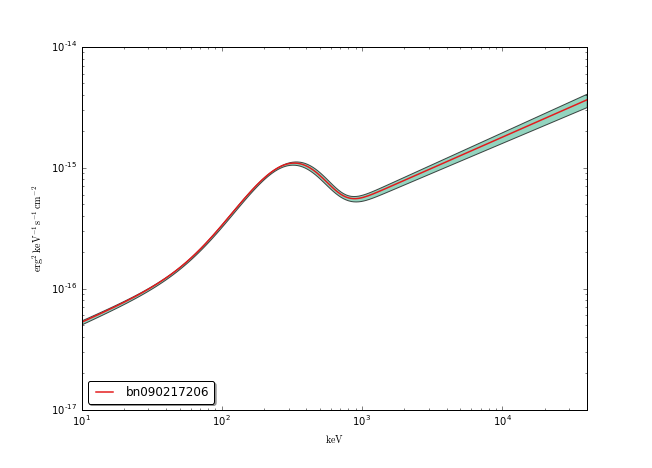

In [6]:
#spec_plot_mle = SpectralPlotter(jl)

plot_point_source_spectra(jl,
                          flux_unit='erg2/(cm2 s keV)')


<IPython.core.display.Javascript object>


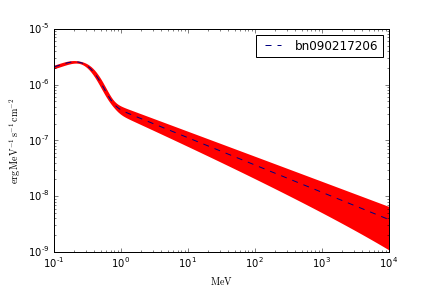

In [8]:
plot_point_source_spectra(jl,
                          energy_unit='MeV',
                          ene_min=1e-1,
                          ene_max=1e4,
                          fit_cmap='jet',
                          contour_cmap='rainbow_r',
                          sigma=3,
                          flux_unit='erg/(cm2 s MeV)',
                          legend_kwargs={'loc':'upper right'},
                          plot_style_kwargs={'linestyle':'--'},
                          contour_style_kwargs={'lw':0}
                         )






In [9]:
comp_model.K_1.prior = Log_uniform_prior(lower_bound = 1E-7, upper_bound = 1E-5)
comp_model.K_2.prior = Log_uniform_prior(lower_bound =1E-1,upper_bound = 1E2)
comp_model.index_2.set_uninformative_prior(Uniform_prior)
comp_model.kT_1.prior = Log_uniform_prior(lower_bound =1E1,upper_bound = 1E4)

bayes = BayesianAnalysis(model, data_list)

res= bayes.sample(20,100,500)


Running burn-in of 100 samples...


Sampling...


Mean acceptance fraction: 0.5893


<IPython.core.display.Javascript object>


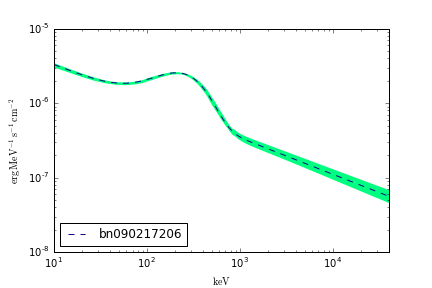

In [12]:
plot_point_source_spectra(bayes,
                          fit_cmap='plasma',
                          contour_cmap='winter',
                          sigma=2,
                          flux_unit='erg/(cm2 s MeV)',
                          legend_kwargs={'loc':'lower left'},
                          plot_style_kwargs={'linestyle':'--'},
                          contour_style_kwargs={'lw':0},
                          fraction_of_samples=.01
                         )

<IPython.core.display.Javascript object>


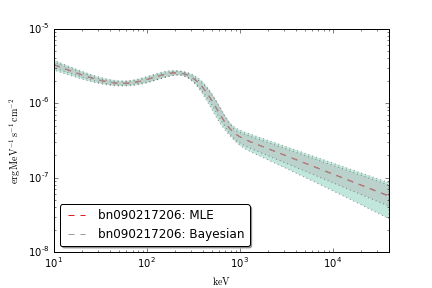

In [19]:
plot_point_source_spectra(bayes,jl,
                          sigma=4,
                          flux_unit='erg/(cm2 s MeV)',
                          plot_style_kwargs={'linestyle':'--'},
                          contour_style_kwargs={'lw':1,'linestyle':':','alpha':0.4},
                          fraction_of_samples=.01
                         )

<IPython.core.display.Javascript object>


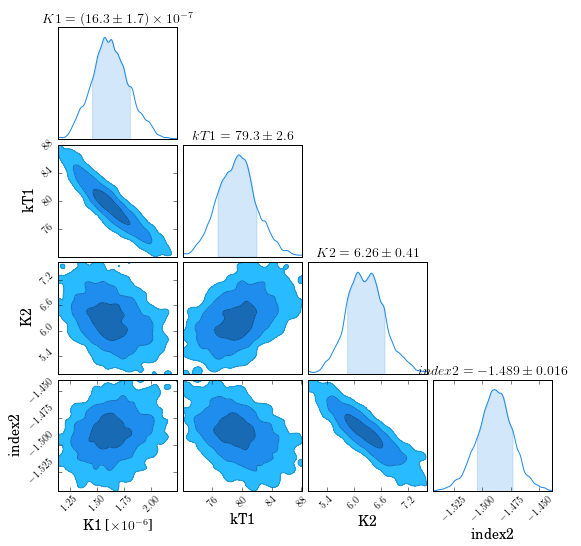

In [15]:
_=bayes.corner_plot_cc()